In [ ]:
#!/usr/bin/python
# updated DBR 02/2025 #

%matplotlib inline

import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import resource; resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

import os

sns.set_style("ticks")

import warnings
warnings.filterwarnings(action='once')


In [2]:
#first do the experiment on those without TN

PWH_ppts2 = ['PWH-1','PWH-2','PWH-3','PWH-4','PWH-5']
ctl_ppts2 = ['Ctl-1','Ctl-2','Ctl-3','Ctl-4','Ctl-5']

PWH_ppts = ['PWH22','PWH548','PWH746','PWH583','PWH1211']
ctl_ppts = ['MACS10136','MACS13042','MACS14173','WIHS','MACS14218']

PWH_cz=['salmon','peru','red','tab:red','maroon',]
ctl_cz=['lightblue','teal','tab:blue','navy','turquoise']

cz=PWH_cz+ctl_cz
pp=PWH_ppts+ctl_ppts
pp2=PWH_ppts2+ctl_ppts2
hs=[1,1,1,1,1,0,0,0,0,0] #HIV status


In [3]:
## collect expansion and contraction data will use for fitting ##

#big lists of changes
bigl=[]
sample_size=10000

for ip,pid in enumerate(pp):
    
    df0 = pd.read_csv('data/clean/TCR/restricted/'+pid+'_t0.csv') #note this hasn't been downsampled yet
    df1 = pd.read_csv('data/clean/TCR/restricted/'+pid+'_t1.csv') 
    df2 = pd.read_csv('data/clean/TCR/restricted/'+pid+'_t2.csv') 

    #the df holding all rearrangements that are present at any time (merge and reformat a little)
    all_df = pd.merge(df0, df1, how='outer', on=['extended_rearrangement'])
    all_df = pd.merge(all_df, df2, how='outer', on=['extended_rearrangement'])
    all_df = all_df.fillna(0) #fill all zeros

    all_df = all_df.rename(columns={'templates_x': 'counts_t0', 'templates_y': 'counts_t1', 'templates': 'counts_t2'})
    
    #now make resampled dataframes
    rs_df=pd.DataFrame()
    pa_df=pd.DataFrame()
    #if I drop zeros here is it faster?
    #pa_df=pa_df.replace(0,np.nan).dropna() #just get nonzeros for visualization on log scale
    for tp in range(3):
        N=np.sum(all_df['counts_t'+str(tp)])
        pa_df['pa'+str(tp)] = all_df['counts_t'+str(tp)]/N
        rs_df['rs'+str(tp)]= np.random.multinomial(n=sample_size,pvals=pa_df['pa'+str(tp)])
        
    #loop over 0-1 and 1-2 time points
    for i in range(2):
        
        pa_i=rs_df['rs'+str(i)]/sample_size
        pa_f=rs_df['rs'+str(i+1)]/sample_size
        
        #pa_f=pa_df['pa'+str(i+1)]
        #pa_i=pa_df['pa'+str(i)]

        #final_sizes = pa_f[(pa_i>0) & (pa_f>0)]
        
        initforchange = pa_i[(pa_i>0) & (pa_f>0)]
        fold_changes = pa_f[(pa_i>0) & (pa_f>0)]/pa_i[(pa_i>0) & (pa_f>0)] #restrict to nonzeros (to avoid nan)

        bigl.append([pp2[ip],i+1,cz[ip],np.array(pa_i),np.array(pa_f),np.array(fold_changes),np.array(initforchange),N])


In [4]:
len(bigl)

20

In [5]:
#make an average and fit it with polynomial

binz=np.arange(0,30,1)+1
avgl=[0,0,0,0]
last_x = 10 #how far to go out for fits

for ipt,pt in enumerate(bigl):
    fcs=np.array(pt[5])
    expands = fcs[fcs>1]
    contracts = 1/fcs[fcs<1]
    ce,xe = np.histogram(expands,bins=binz,density=True)
    cc,xc = np.histogram(contracts,bins=binz,density=True)
    
    if 'PWH' in pt[0]:
        avgl[0]+=ce
        avgl[1]+=cc
    
    if 'Ctl' in pt[0]:
        avgl[2]+=ce
        avgl[3]+=cc
        

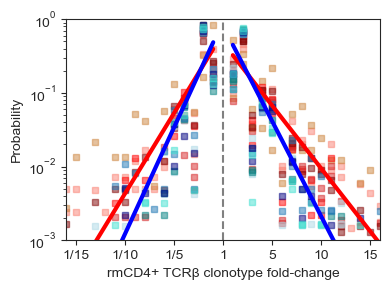

In [14]:
#now do histograms of all data with mean line
binz=np.arange(0,30,1)+1
mz='s'
plt.figure(figsize=(4,3))
laml=[]
for ipt,pt in enumerate(bigl):
    fcs=np.array(pt[5])
    expands = fcs[fcs>1]
    contracts = 1/fcs[fcs<1]
    
    ce,xe = np.histogram(expands,bins=binz,density=True)
    cc,xc = np.histogram(contracts,bins=binz,density=True)

    plt.plot(xe[:-1],ce,color=pt[2],marker=mz,ls='',alpha=0.5,markersize=5)
    plt.plot(-xc[:-1],cc,color=pt[2],marker=mz,ls='',alpha=0.5,markersize=5)

    #deal with nan
    ce[ce==0]=np.min(ce[ce>0])
    cc[cc==0]=np.min(cc[cc>0])
    
    fit_lame, fit_y0 = np.polyfit(xe[:last_x],np.log(ce[:last_x]),1)
    fit_lamc, fit_y0 = np.polyfit(xe[:last_x],np.log(cc[:last_x]),1)
    
    laml.append([pt[0],fit_lame,fit_lamc]) #list for lambdas

xx=xe[:-1]
for ai in range(4):
    c=avgl[ai]/10
    fit_lam, fit_y0 = np.polyfit(xe[:last_x],np.log(c[:last_x]),1)

    fex=np.exp(fit_y0)*np.exp(fit_lam*xx)
    fex=fex/np.sum(fex)
    
    if ai<2:
        cz='red'
    else:
        cz='blue'
    
    if ai in [0,2]:
        plt.plot(xx,fex,ls='-',color=cz,lw=3)
    else:
        plt.plot(-xx,fex,ls='-',color=cz,lw=3)

plt.semilogy()
plt.ylim([1e-3,1])
plt.ylabel('Probability')
plt.xlabel('rmCD4+ TCRβ clonotype fold-change')
plt.xticks(np.linspace(-20,20,9),['1/20','1/15','1/10','1/5','1','5','10','15','20'])
plt.xlim([-16,16])
plt.axvline(0,ls='--',color='gray')

plt.tight_layout()
plt.savefig('figures/allfoldchanges.pdf',dpi=600)    


In [15]:
#make df and output for fitting
lamdf=pd.DataFrame(laml,columns=['pid','lam_expand','lam_contract'])

lamdf.to_csv('data/clean/expcontr.csv')

In [16]:
#do tests

#PWH vs HIVneg expand
print(st.mannwhitneyu(lamdf.iloc[:10]['lam_expand'],lamdf.iloc[10:]['lam_expand']))

#PWH expand vs contract
print(st.mannwhitneyu(lamdf.iloc[:10]['lam_expand'],lamdf.iloc[:8]['lam_contract']))
print(st.mannwhitneyu(lamdf.iloc[10:]['lam_expand'],lamdf.iloc[10:]['lam_contract']))

#PWH vs HIVneg contract
print(st.mannwhitneyu(lamdf.iloc[:10]['lam_contract'],lamdf.iloc[10:]['lam_contract']))


MannwhitneyuResult(statistic=90.0, pvalue=0.0028272720911168077)
MannwhitneyuResult(statistic=36.0, pvalue=0.7618264088852323)
MannwhitneyuResult(statistic=36.0, pvalue=0.3074894566186813)
MannwhitneyuResult(statistic=70.0, pvalue=0.14046504815835495)


3.663851116128775e-221


/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_13452/2472345403.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.hexbin(np.log10(initsize),np.log10(finalsize),gridsize=(20,20),cmap='viridis_r',mincnt=1,bins='log',vmin=1,vmax=500,alpha=0.8)


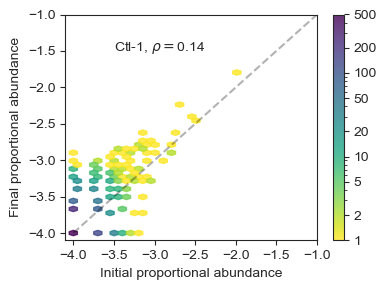

In [17]:
#HEXBIN initial vs final (one example)

ii=10
initsize = bigl[ii][3]
finalsize = bigl[ii][4]

plt.figure(figsize=(4,3))
plt.hexbin(np.log10(initsize),np.log10(finalsize),gridsize=(20,20),cmap='viridis_r',mincnt=1,bins='log',vmin=1,vmax=500,alpha=0.8)

plt.plot([-4,-1],[-4,-1],ls='--',color='black',alpha=0.3)
#plt.title(bigl[ii][0])
plt.annotate(bigl[ii][0]+r', $\rho=$'+str(np.round(st.spearmanr(initsize,finalsize)[0],2)),[-3.5,-1.5])
print(st.spearmanr(initsize,finalsize)[1])

plt.xlabel('Initial proportional abundance')
plt.ylabel('Final proportional abundance')
plt.xticks(np.arange(-4,0,0.5))
plt.yticks(np.arange(-4,0,0.5))
plt.xlim([-4.1,-1])
plt.ylim([-4.1,-1])

cbar=plt.colorbar()
#cbar.set_label(r'# obser')
cbar.set_ticks(np.array([1,2,5,10,20,50,100,200,500]))
cbar.set_ticklabels(np.array([1,2,5,10,20,50,100,200,500]))

plt.tight_layout()
plt.savefig('figures/hexbin_i_f.svg')


/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_13452/957717211.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.hexbin(np.log10(initsize),np.log10(finalsize),gridsize=(20,20),cmap='viridis_r',mincnt=1,bins='log',vmin=1,vmax=500,alpha=0.8)


3.1765618326491346e-115
0.0
2.1140325375599463e-140
0.0
5.480616782818596e-186
0.0
9.954133950214572e-246
0.0
0.0
0.0
3.663851116128775e-221
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


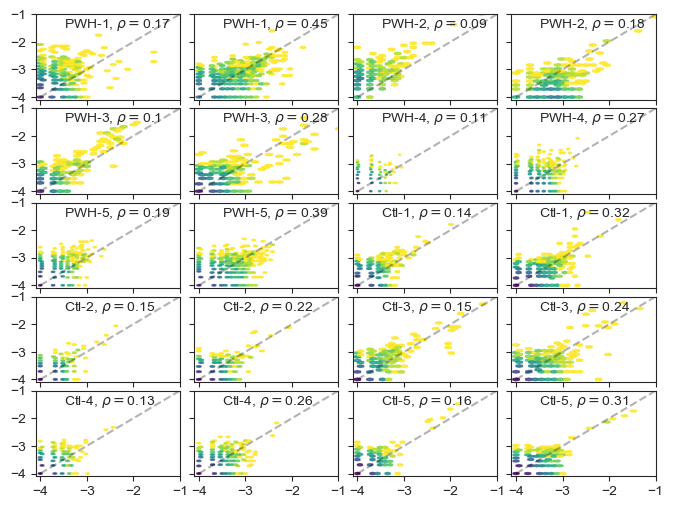

In [18]:
#all initial vs final

fig,axarr=plt.subplots(5,4,sharex=True,sharey=True,figsize=(8,6))
for ii in range(len(bigl)):
    initsize = bigl[ii][3]
    finalsize = bigl[ii][4]

    ax=axarr[int(ii/4)][ii%4]

    ax.hexbin(np.log10(initsize),np.log10(finalsize),gridsize=(20,20),cmap='viridis_r',mincnt=1,bins='log',vmin=1,vmax=500,alpha=0.8)

    ax.plot([-4,-1],[-4,-1],ls='--',color='black',alpha=0.3)
    #plt.title(bigl[ii][0])
    ax.annotate(bigl[ii][0]+r', $\rho=$'+str(np.round(st.spearmanr(initsize,finalsize)[0],2)),[-3.5,-1.5])
    print(st.spearmanr(initsize,finalsize)[1])

plt.xticks(np.arange(-4,0,1))
plt.yticks(np.arange(-4,0,1))
plt.xlim([-4.1,-1])
plt.ylim([-4.1,-1])

plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.savefig('figures/hexbin_i_f_all.svg')


MannwhitneyuResult(statistic=51.0, pvalue=0.9698499769931556)


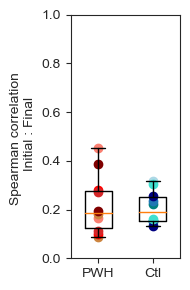

In [19]:
#tabulate correlation coefficients
rl=[]
plt.figure(figsize=(2,3))
for ii in range(len(bigl)):
    initsize = bigl[ii][3]
    finalsize = bigl[ii][4]
    
    rho=st.spearmanr(initsize,finalsize)[0]
    rl.append(rho)
    
    if ii<10:
        plt.scatter(1,rho,c=bigl[ii][2])
    else:
        plt.scatter(2,rho,c=bigl[ii][2])
    
plt.boxplot([rl[:10],rl[10:]],widths=0.5)
plt.ylim([-0,1])
plt.xlim([0.5,2.5])
#plt.xlabel('HIV status')
plt.xticks([1,2],['PWH','Ctl'])
plt.ylabel('Spearman correlation \n Initial : Final')
print(st.mannwhitneyu(rl[:10],rl[10:]))
plt.tight_layout()
plt.savefig('figures/corrs_box1.svg')


1.3214734094198582e-173


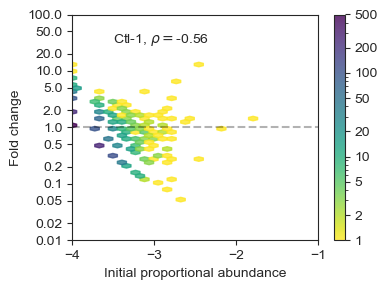

In [20]:
#HEXBIN initial vs foldchange (one example)

ii=11
initsize = bigl[ii][6] #use the one with only persistent
foldchg = bigl[ii][5]

plt.figure(figsize=(4,3))
plt.hexbin(np.log10(initsize),np.log10(foldchg),gridsize=(20,20),cmap='viridis_r',mincnt=1,bins='log',vmin=1,vmax=500,alpha=0.8)

plt.axhline(0,ls='--',color='black',alpha=0.3)
#plt.title(bigl[ii][0])
plt.annotate(bigl[ii][0]+r', $\rho=$'+str(np.round(st.spearmanr(initsize,foldchg)[0],2)),[-3.5,1.5])
print(st.spearmanr(initsize,foldchg)[1])

plt.xlabel('Initial proportional abundance')
plt.ylabel('Fold change')
yy=np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000])

#plt.xticks(np.log10(yy),yy)
plt.yticks(np.log10(yy),yy)
plt.ylim([-2,2])
#plt.xticks(np.log10(np.array([1,2,5,10,20,50,100,200,500,1000])),np.array([1,2,5,10,20,50,100,200,500,1000]))
plt.xlim([-4,-1])

cbar=plt.colorbar()
cbar.set_ticks(np.array([1,2,5,10,20,50,100,200,500]))
cbar.set_ticklabels(np.array([1,2,5,10,20,50,100,200,500]))

plt.tight_layout()
plt.savefig('figures/hexbin_i_del.svg')


In [ ]:
#HEXBIN initial vs foldchange ALL

fig,axarr=plt.subplots(5,4,sharex=True,sharey=True,figsize=(8,6))
for ii in range(len(bigl)):

    ax=axarr[int(ii/4)][ii%4]

    initsize = bigl[ii][6] #use the one with only persistent
    foldchg = bigl[ii][5]

    ax.hexbin(np.log10(initsize),np.log10(foldchg),gridsize=(20,20),cmap='viridis_r',mincnt=1,bins='log',vmin=1,vmax=500,alpha=0.8)

    ax.axhline(0,ls='--',color='black',alpha=0.3)
    ax.annotate(bigl[ii][0]+r', $\rho=$'+str(np.round(st.spearmanr(initsize,foldchg)[0],2)),[-3.5,1.5])
    print(st.spearmanr(initsize,foldchg)[1])

#yy=np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000])
#plt.yticks(np.log10(yy),yy)
plt.xticks(range(-4,0,1))
plt.yticks(range(-2,3,1))
plt.ylim([-2,2])
plt.xlim([-4,-1])

plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.savefig('figures/hexbin_i_del_all.svg')


In [ ]:
#tabulate correlation coefficients
rl=[]
plt.figure(figsize=(2,3))
for ii in range(len(bigl)):
    initsize = bigl[ii][6] #use the one with only persistent
    foldchg = bigl[ii][5]
    
    rho=st.spearmanr(foldchg,initsize)[0]
    rl.append(rho)
    
    if ii<10:
        plt.scatter(1,rho,c=bigl[ii][2])
    else:
        plt.scatter(2,rho,c=bigl[ii][2])
    
plt.boxplot([rl[:10],rl[10:]],widths=0.5)
plt.ylim([-1,0])
plt.xlim([0.5,2.5])
#plt.xlabel('HIV status')
plt.xticks([1,2],['PWH','Ctl'])
plt.ylabel('Spearman correlation \n Abundance : Fold-change')
print(st.mannwhitneyu(rl[:10],rl[10:]))
plt.tight_layout()
plt.savefig('figures/corrs_box2.svg',dpi=600)


In [ ]:
#output summary stats

pd.DataFrame(rl,columns=['init_foldchg_rho']).to_csv('data/clean/init_foldchg_rho.csv')